In [1]:
from tsnecuda import TSNE
import numpy as np
import os
import PIL.ImageOps
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [24]:
# spg_features, QuickDraw_features, 
feature_folder = "/raid/xiaoyuz1/sketch_datasets/spg_features/clip/angel"
flip = False
# feature_folder = "/raid/xiaoyuz1/sketch_datasets/QuickDraw_features/clip/dragon"
# flip = True

# feature_folder = "/raid/xiaoyuz1/sketch_datasets/spg_body/angel_feature"
# flip = False

In [25]:
# L = []
# folder = '/raid/xiaoyuz1/sketch_datasets/angel'
# for file in os.listdir(folder):
#     if not file.endswith("png"):
#         continue
    
#     L.append(file)
# print(len(L))

In [26]:
all_features = []
all_images = []

for file in os.listdir(feature_folder):
    print(file)
    if not file.endswith(".npy"):
        continue
        
    img_path = "{}.txt".format(file.split(".n")[0])
    feat = np.load(os.path.join(feature_folder, file))
    print(feat.shape)
    # all_features.append(feat)
    image_paths = None
    with open(os.path.join(feature_folder, img_path), 'r') as f:
        lines = f.readlines()
        image_paths = [line.strip() for line in lines]
        #all_images += image_paths
    print(len(image_paths))
        
    for feati,pathi in zip(feat,image_paths):
        #if pathi.split("/")[-1] in L:
        all_features += [feati]
        all_images += [pathi]

0.txt
0.npy
(714, 128)
714


In [27]:
features = np.vstack(all_features)
print(features.shape)

(714, 128)


In [28]:
# tsne = TSNE(n_iter=1000, verbose=1, num_neighbors=128)
tsne = TSNE(n_iter=5000, verbose=1, perplexity=5000, num_neighbors=128)
tsne_results = tsne.fit_transform(features)

In [29]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

tx = scale_to_01_range(tsne_results[:,0])
ty = scale_to_01_range(tsne_results[:,1])

In [31]:
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape
    center_x = int(image_centers_area_size * x) + offset
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y


def visualize_tsne_images(tx, ty, images, labels = None, plot_size=1000, max_image_size=100, flip=False):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
    
    plt.figure(figsize=(30,30))

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for image_path, x, y in tqdm(
        zip(images, tx, ty),
        desc='Building the T-SNE plot',
        total=len(images)
    ):
        image = cv2.imread(image_path)
        # print(image_path)
        if flip:
            image = cv2.bitwise_not(image)

        image = scale_image(image, max_image_size)

        ### draw a rectangle with a color corresponding to the image class
        ## image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

Building the T-SNE plot: 100%|██████████| 714/714 [00:00<00:00, 1325.81it/s]


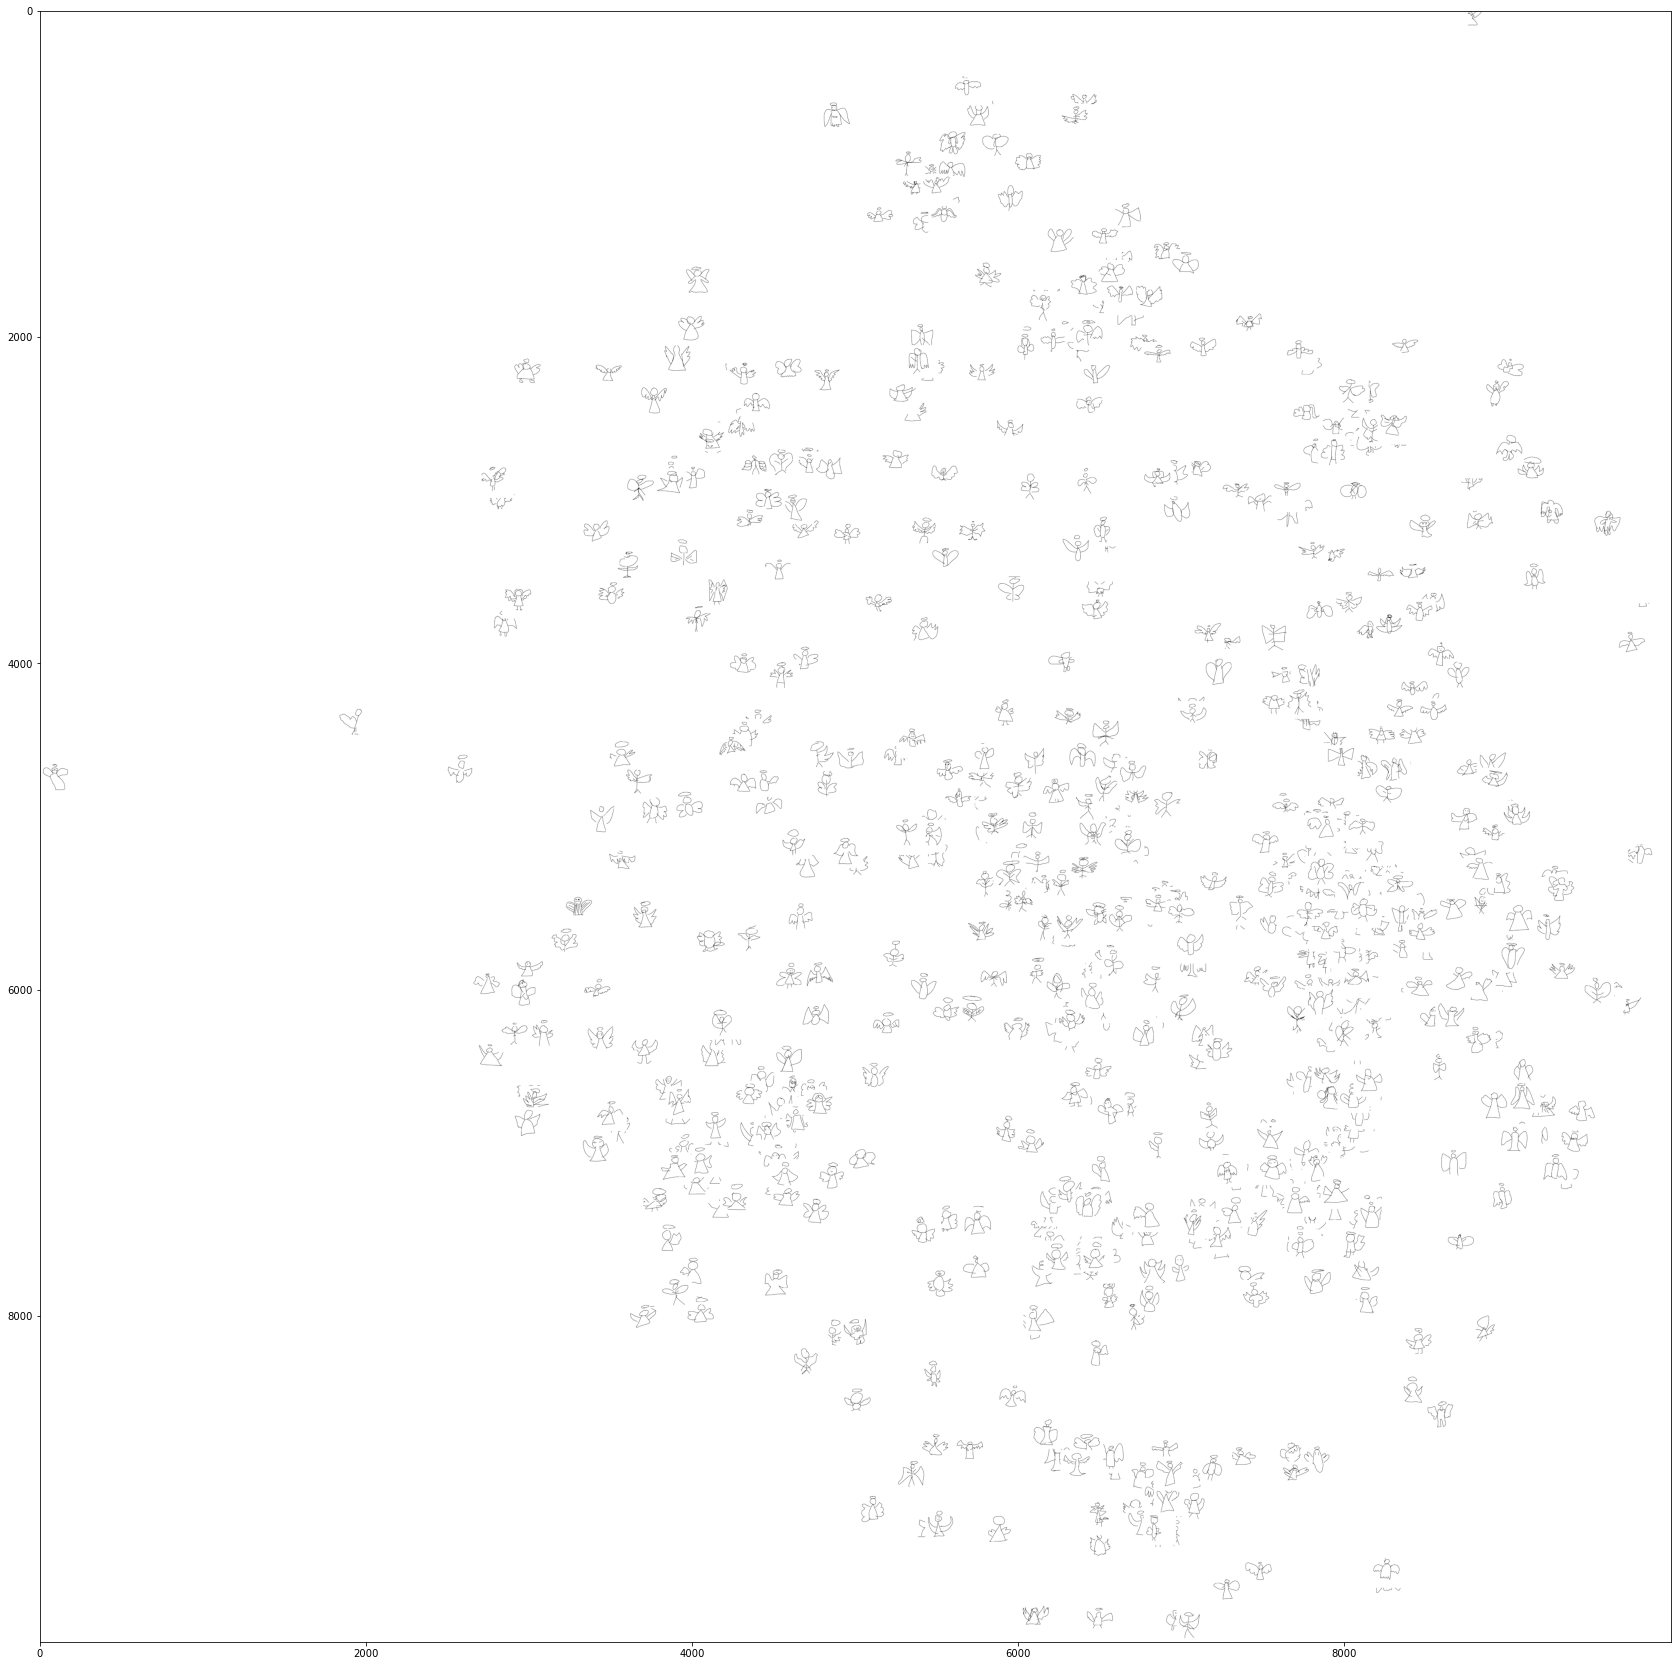

In [32]:
visualize_tsne_images(tx, ty, all_images, plot_size=10000, max_image_size=200, flip=flip)

In [10]:
# tsne_fdr = os.path.join(feature_folder, 'tsne_results_perplexity15000')
# if not os.path.exists(tsne_fdr):
#     os.mkdir(tsne_fdr)

# with open(os.path.join(tsne_fdr, 'tsne_x.npy'), 'wb') as f:
#     np.save(f, tx)
    
# with open(os.path.join(tsne_fdr, 'tsne_y.npy'), 'wb') as f:
#     np.save(f, ty)  

# with open(os.path.join(tsne_fdr, 'image.txt'), "w+") as f:
#     f.write("\n".join(all_images))

In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=80, random_state=22)
pca.fit(features)
x = pca.transform(features)

In [40]:
kmeans = KMeans(n_clusters=10, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=10, random_state=22)

In [41]:
groups = {}
for file, cluster in zip(all_images, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [42]:
import PIL
def view_cluster(cluster, save_path=None):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
#     if len(files) > 30:
#         print(f"Clipping cluster size from {len(files)} to 30")
#         files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(20,20,index+1);
        img = PIL.Image.open(file)
        img = img.convert(mode='RGB')
        
        if flip:
            img = PIL.ImageOps.invert(img)
        
        
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    plt.close()

0 24


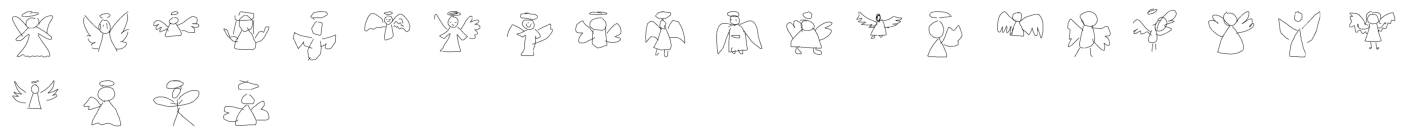

8 122


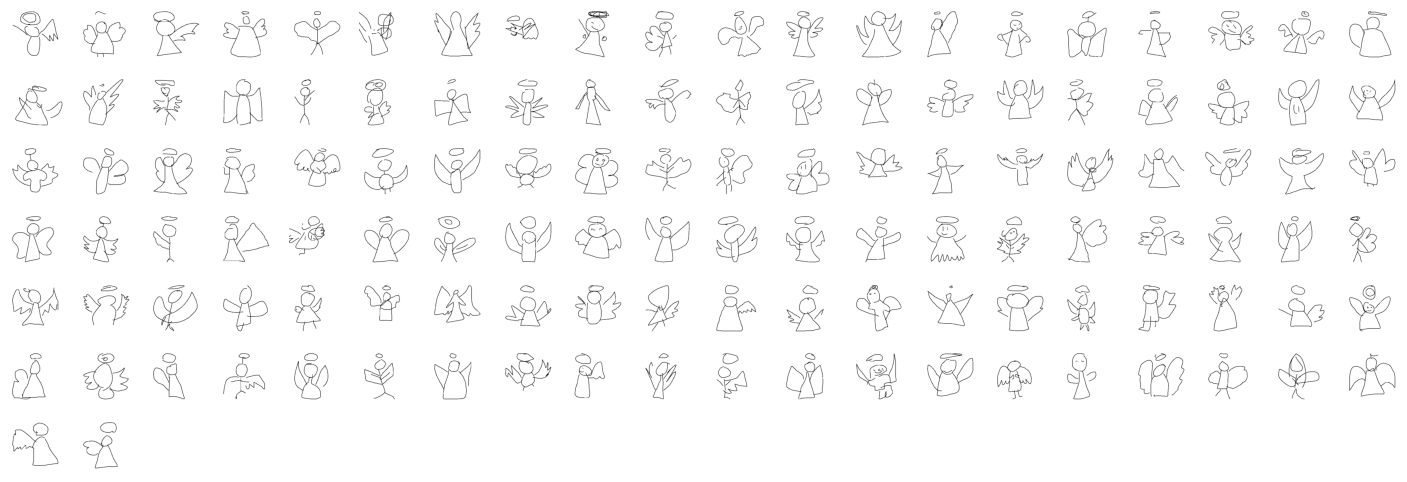

2 52


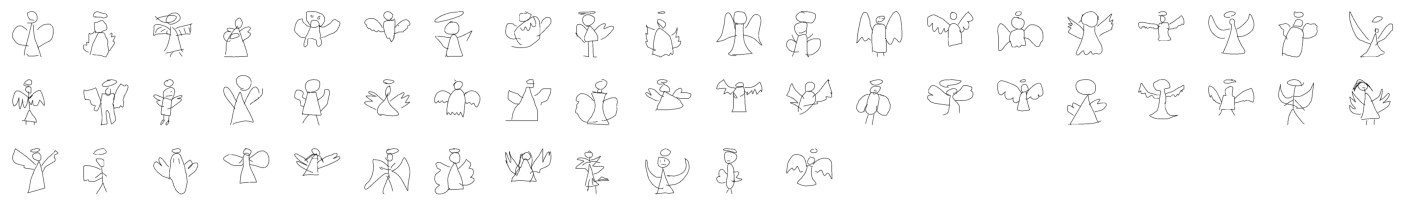

5 82


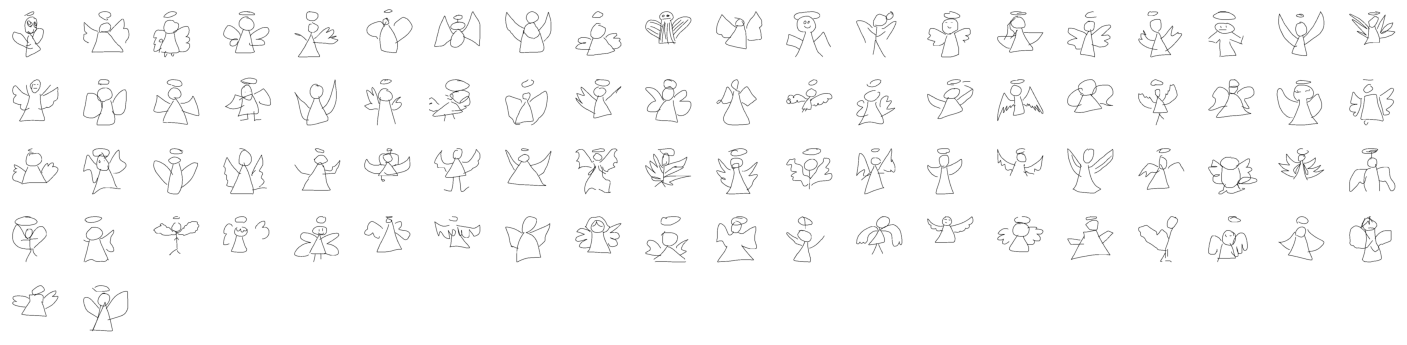

1 156


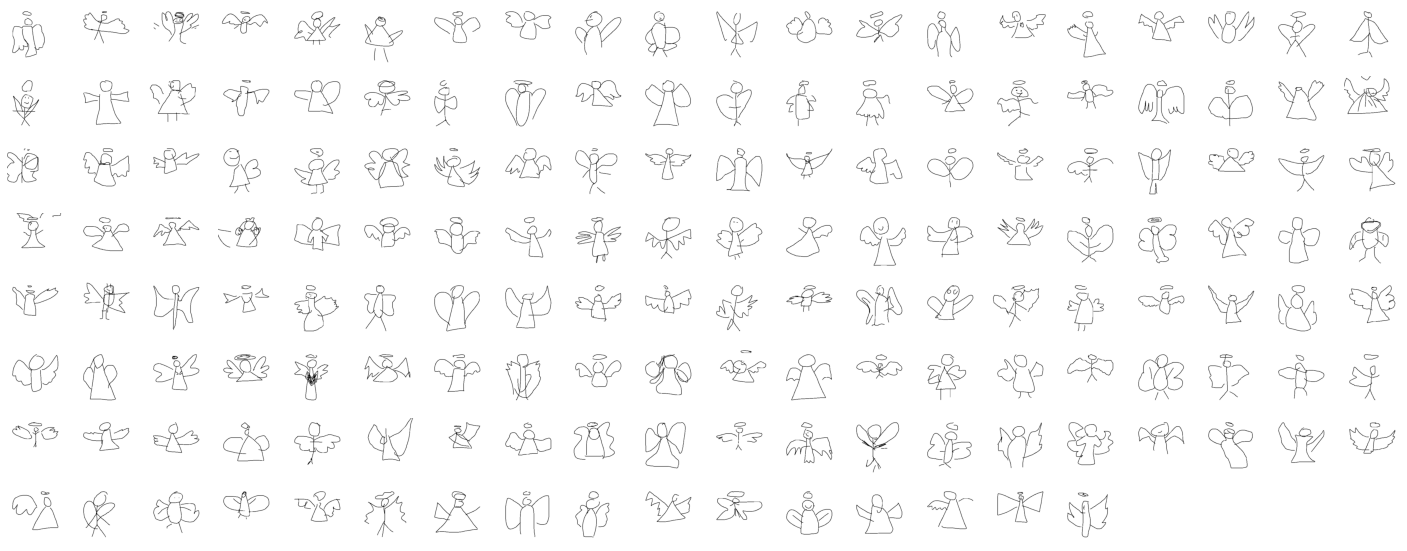

6 93


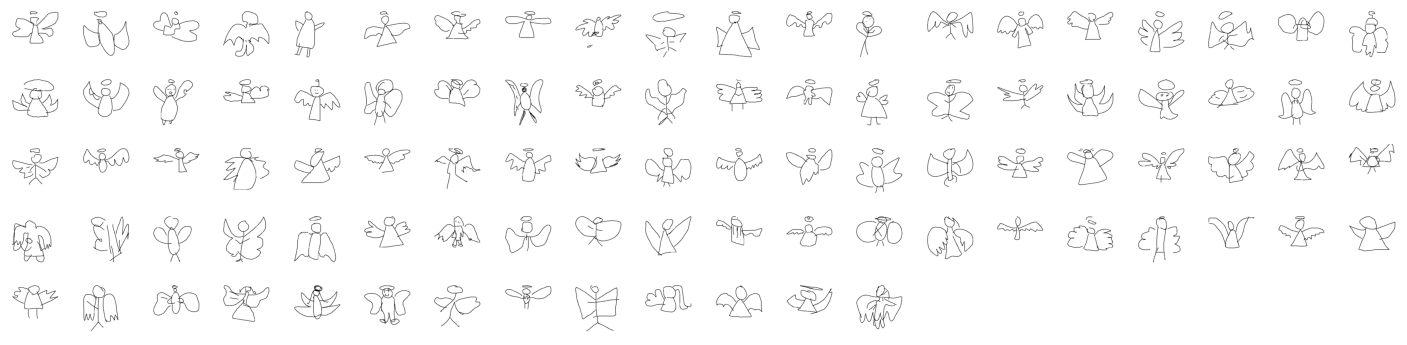

7 78


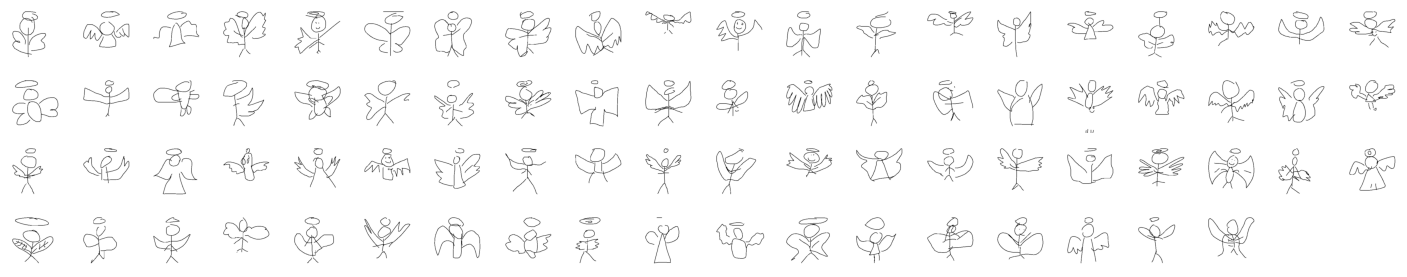

9 50


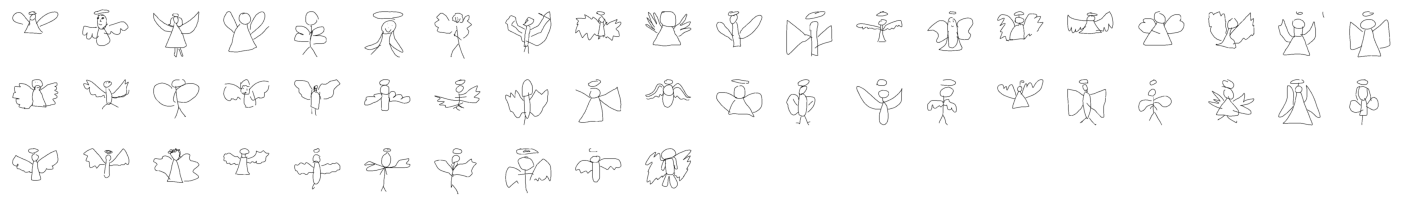

3 51


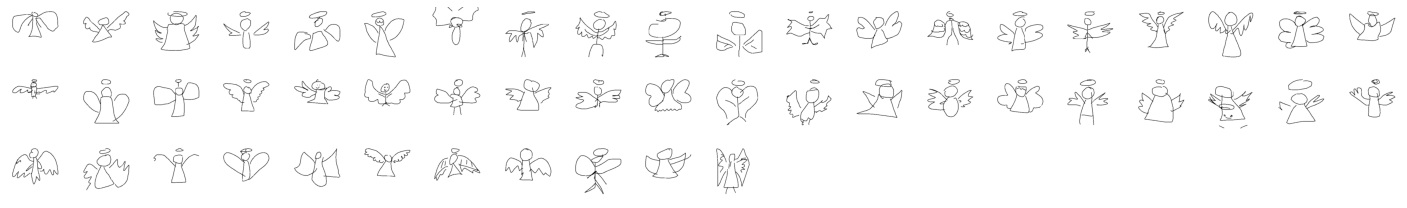

4 6


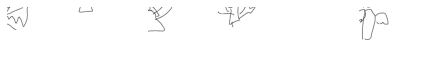

In [43]:
cluter_fdr = os.path.join(feature_folder, 'type1_clustering_result')
if not os.path.exists(cluter_fdr):
    os.mkdir(cluter_fdr)
    
for k in groups:
    save_path = os.path.join(cluter_fdr, 'cluster_{}.png'.format(k))
    print(k, len(groups[k]))
    view_cluster(k, save_path = save_path)

In [16]:
# # this is just incase you want to see which value for k might be the best 
# sse = []
# list_k = list(range(3, 50))

# for k in list_k:
#     km = KMeans(n_clusters=k, random_state=22)
#     km.fit(x)
    
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance')